## This notebook demonstrates the flow of a visual search project that enables users to locate relevant images based on natural language queries while providing AI-driven explanations for the search results. 


`Data preprocessing`: Image resizing, CLIP embeddings, BLIP captions.  
`Database`: SQLite storing filenames & captions.  
`Indexing`: FAISS on combined embeddings for fast retrieval.  
`API`: FastAPI exposing health & search endpoints.  
`Explanation`:   
    > Note: I originally intended to use an LLM for explanations combining query and caption, but due to disk space constraints, I only store captions as a proxy for explanations.  
`Docker`: Makes the service portable and easy to run.  

## Preprocessing and Index Building

The first step is to preprocess images, generate embeddings, captions, and build the FAISS index for efficient similarity search.

**Steps:**
1. Load images from the `images/` directory.
2. Preprocess images with **CLIP ViT-L/14** for embeddings.
3. Generate captions using **BLIP**.  
4. Combine image and caption embeddings by averaging.
5. Store image filename and caption in a **SQLite database** (`images.db`).
6. Build a **FAISS index** (`faiss_index.bin`) on combined embeddings.

**Preprocessing done:**
- Images resized & normalized for CLIP.
- Captions generated using BLIP.
- CLIP embeddings normalized (L2 norm).


In [2]:
import requests
from PIL import Image
from IPython.display import display

The FastAPI app (app.py) provides the following endpoints:  
  
GET `/health` - Returns service status.   
GET `/` - Home page showing intuitive web interface for users to interact with the system. (A snapshot included along with submission files).  
GET `/search?query=<text>&topk=<int>` - Returns top-K search results with captions.  
  
`Note:` Caption as explanation:  
Due to hardware constraints, the explain_image() function only returns BLIP-generated captions instead of full LLM explanations.  

I have included a Dockerfile and docker-compose.yml:  

`Dockerfile`
- Installs dependencies.  
- Copies source code.  
- Exposes port 8001.  
- Runs uvicorn app:app. 
 
`docker-compose.yml`
- Mounts local images, images.db, and faiss_index.bin.  
- Maps container port 8001 to host.  
- Ensures the container restarts unless stopped.  

## Health Check

In [13]:
BASE_URL = "http://localhost:8001"

try:
    response = requests.get(f"{BASE_URL}/health")
    if response.status_code == 200:
        print("Health endpoint response:")
        print(response.json())
    else:
        print(f"Health endpoint returned status code: {response.status_code}")
except Exception as e:
    print(f"Error connecting to health endpoint: {e}")

Health endpoint response:
{'status': 'ok', 'message': 'Service is running'}


## Searching Images

The search functionality is implemented in `search.py`.

**Steps:**
1. Query text is tokenized and embedded using CLIP.
2. FAISS index is queried for top-K similar images.
3. Results include filename, similarity score, and BLIP-generated caption.

In [14]:
# A helper function to query the FastAPI search endpoint
def search_images(query, topk=5, endpoint="http://127.0.0.1:8001/search"):
    response = requests.get(f"{endpoint}?query={query}&topk={topk}")
    return response.json()

In [10]:
query = "sunset on beach"
res = search_images(query, topk=5)


In [11]:
print("Top results:")
for r in res:
    print(f"Filename: {r['filename']}, Score: {r['score']:.4f}, Explanation: {r['explanation']}")


Top results:
Filename: 0490.jpg, Score: 0.7751, Explanation: a sunset on the beach
Filename: 0032.jpg, Score: 0.6819, Explanation: a sunset on the beach with a blur of the sky
Filename: 0116.jpg, Score: 0.6726, Explanation: a sunset at the beach with a view of the city
Filename: 0149.jpg, Score: 0.6213, Explanation: a man walking on the beach at sunset
Filename: 0285.jpg, Score: 0.6205, Explanation: a beach with rocks and water at sunset


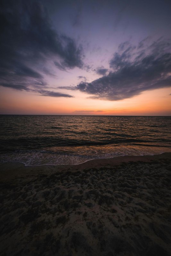

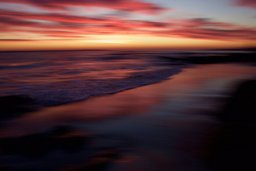

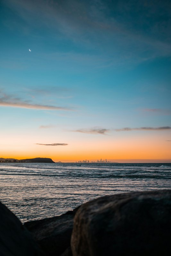

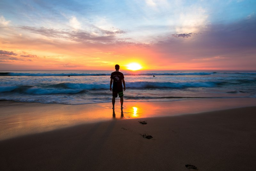

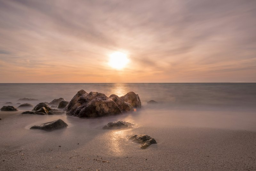

In [8]:
for r in res:
    img = Image.open(f"images/{r['filename']}")
    img.thumbnail((256,256))  # Resizing for display
    display(img)


# Showing some more results generated by this system


Query: Flowers
Filename: 0411.jpg, Score: 0.6252, Explanation: a bunch of pink flowers


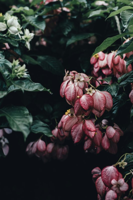

Filename: 0281.jpg, Score: 0.6192, Explanation: a close up of a tree with flowers


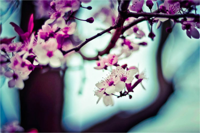

Filename: 0220.jpg, Score: 0.6010, Explanation: a bouquet of purple flowers


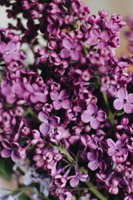

Filename: 0019.jpg, Score: 0.5959, Explanation: a bouquet of tulips


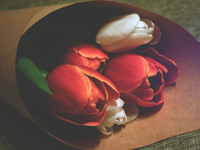

Filename: 0205.jpg, Score: 0.5839, Explanation: white flowers in the garden


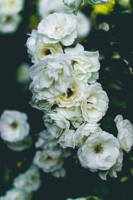


Query: Snow capped trees
Filename: 0432.jpg, Score: 0.6964, Explanation: snowy trees in the mountains


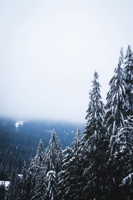

Filename: 0404.jpg, Score: 0.6535, Explanation: a mountain with snow on it and trees in the fore


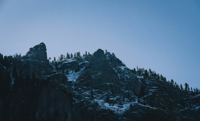

Filename: 0207.jpg, Score: 0.5957, Explanation: a mountain covered in snow


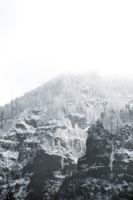

Filename: 0165.jpg, Score: 0.5881, Explanation: a mountain covered in snow with trees and mountains in the background


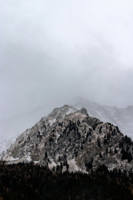

Filename: 0258.jpg, Score: 0.5739, Explanation: a road with trees covered in snow


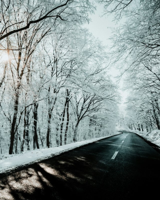

In [9]:
queries = ["Flowers", "Snow capped trees"]

for q in queries:
    print(f"\nQuery: {q}")
    results = search_images(q, topk=5)
    for r in results:
        print(f"Filename: {r['filename']}, Score: {r['score']:.4f}, Explanation: {r['explanation']}")
        img = Image.open(f"images/{r['filename']}")
        img.thumbnail((200,200))
        display(img)


## THANK YOU! :)